## Replication of <*Nonlinear Dynamics of Crime and Violence in Urban Settings*> by 六月初四

### Figure 3. Dependence of the number of active citizens per day (in percent) on the number of LEOs per 1,000 citizens for population corresponding to different lattices' sizes. (p. 6)

In [1]:
import numpy as np
import random
import math
from statistics import *
import matplotlib.pyplot as plt 
from matplotlib import colors as c
from matplotlib import style
style.use('ggplot')

def get_distant(point1, point2):
    return ((point1[0] - point2[0]) ** 2 + (point1[1] - point2[1]) ** 2) ** 0.5

class lattice:
    def __init__(self, size:int, functionForm:str):
        self.size = int(size)
        self.map = np.full((self.size, self.size), 0) # 存放每個 position 的 status (status定義見下)
        self.citizens = [] # 存放 citizen 與 LEO 物件的 List
        self.LEOs = []
        self.IDMap = np.full((size, size), '---', dtype='<U8') # 每個 position 格子中的 agent，分別是在上面 List的哪個位置
        self.IDs = [] # 存放每個 agent 的 ID (前面是 citizen，後面是 LEO)
        self.hadPlacedAgent = False
        self.functionForm = functionForm
        
    def place_agents(self, citizen_density:float, LEO_num:int, alwaysAcitve:float, neverActive:float):
        self.hadPlacedAgent = True
        self.citizen_density = citizen_density
        self.citizen_num = int((self.size ** 2) * self.citizen_density)
        self.LEO_num = int(LEO_num)
        self.LEO_ratio = self.LEO_num / (self.citizen_num / 1000)
        self.population = int(self.citizen_num * self.Ac)
        self.alwaysAcitve = alwaysAcitve
        self.neverActive = neverActive
        self.alwaysAcitve_start_index = int(self.citizen_num * self.alwaysAcitve)
        self.neverAcitve_end_index = int(self.citizen_num * (self.alwaysAcitve + self.neverActive))
        
        self.unoccupied_position_index = list(range(self.size**2))
        all_poistion_index = random.sample(self.unoccupied_position_index, self.citizen_num+self.LEO_num)
        citizen_positions_index = all_poistion_index[:self.citizen_num]
        LEO_positions_index = all_poistion_index[self.citizen_num:]
        
        for i, p in enumerate(citizen_positions_index): 
            x = int(p / self.size)
            y = int(p % self.size)
            if (i+1) <= self.alwaysAcitve_start_index : # 依照 alwaysAcitve 的比例，將前面數量的 citizens 設為 alwaysAcitve
                self.citizens.append(citizen(self, "C"+str(i), x, y, 1))
            elif (i+1) <= self.neverAcitve_end_index: # 依照 neverActive 的比例，將接續數量的 citizens 設為 neverActive
                self.citizens.append(citizen(self, "C"+str(i), x, y, -1))
            else:
                self.citizens.append(citizen(self, "C"+str(i), x, y, 0)) # 最後把 conditionally active 的 citizens 放入 List 中
        for i, p in enumerate(LEO_positions_index):
            x = int(p / self.size)
            y = int(p % self.size)
            self.LEOs.append(LEO(self, "L"+str(i), x, y))

        self.IDs = ["C"+str(i) for i in range(self.citizen_num)] + ["L"+str(i) for i in range(self.LEO_num)]
        
    def set_up_citizens(self):
        for c in self.citizens[self.neverAcitve_end_index:]:
            c.set_perceivedNetRisk(self, self.functionForm) 
        for c in self.citizens[:self.alwaysAcitve_start_index]:
            c.toJail(self) # place “always active” citizens in the jail
            
    def get_status(self, x, y):
        if (x >= 0) and (y >= 0) and (x < self.size) and (y < self.size):
            return self.map[x, y]
        else:
            return -1
        
    def get_ID(self, x, y):
        if (x >= 0) and (y >= 0) and (x < self.size) and (y < self.size):
            return self.IDMap[x, y]
        else:
            return '~~'
        
    def set_status_ID(self, x, y, status, ID): 
        '''
        PLEASE use this method to change lattice's value, rather than directly change. (因為會會自動判斷是所要修改的位置，是否超出棋盤)
        status -> -1:out of lattice; 0:unoccupied ; 1:LEO ; 2:citizen(quiescent) ; 3:citizen(active); 4 citizen(in jail)
        請注意，也同時需設定 IDMap
        '''
        if (x >= 0) and (y >= 0) and (x < self.size) and (y < self.size):
            position_index = (x * self.size) + y
            if (self.map[x, y] in [1, 2, 3]) and (status in [0, 4]):
                self.unoccupied_position_index.append(position_index)
            if (self.map[x, y] in [0, 4]) and (status in [1, 2, 3]):
                self.unoccupied_position_index.remove(position_index)
            self.map[x, y] = status
            self.IDMap[x, y] = ID        
            
    def switch_status(self, position1, position2, ID1, ID2):
        temp = self.get_status(position1[0], position1[1])
        self.set_status_ID(position1[0], position1[1], self.get_status(position2[0], position2[1]), ID2)
        self.set_status_ID(position2[0], position2[1], temp, ID1)
        
    def get_status_in_vision(self, x, y, vision):
        positions_in_vision = []
        for i in range(-vision, vision+1):
            for j in range(-vision, vision+1):
                if (abs(i) + abs(j)) <= vision * 1.5:
                    if self.get_status(x+i, y+j) > 0:
                        if get_distant((x+i, y+j), (x, y)) <= (vision + 0.25): #  用圓心（但此用左下角的座標來代替）來計算兩個格子的距離。關鍵是半徑要加 0.25 (WHY?
                            positions_in_vision.append((x+i, y+j, self.get_status(x+i, y+j)))
        return np.asanyarray(positions_in_vision)
    
    def each_time_step(self):
        global LEO_speed
        this_time_agents_order = self.IDs + (self.IDs[self.citizen_num:] * LEO_speed)
        random.shuffle(this_time_agents_order)

        for i in this_time_agents_order:
            agent_type = i[0]
            index = int(i[1:])
            if agent_type == 'C':
                c = self.citizens[index]
                if c.jail == -1:
                    c.move(self)
                elif c.jail == 0:
                    c.jail = -1
                    p = random.choice(self.unoccupied_position_index)
                    x = int(p / self.size)
                    y = int(p % self.size)
                    if c.activeType == 1:
                        status = 3
                    else:
                        status = 2
                    self.set_status_ID(c.position_x, c.position_y, status, c.ID)
                    self.switch_status((c.position_x, c.position_y), (x, y), c.ID, self.get_ID(x, y))
                    c.position_x = x
                    c.position_y = y
                else:
                    c.jail -= 1
                c.set_perceivedNetRisk(self, self.functionForm)
                        
            else: # Agent is LEO
                L = self.LEOs[index]         
                L.arrest(self)
                L.move(self)
        
    def get_info(self):
        if self.hadPlacedAgent:
            information = {'size': self.size,
                           'agent_num': self.LEO_num + self.citizen_num,
                           'LEO_num': self.LEO_num,
                           'citizen_num': self.citizen_num,
                           'inactive_num': (self.map == 2).sum(),
                           'active_n': (self.map == 3).sum(),
                           'inJail_n': (self.map == 4).sum(),
                           'population': self.population,
                           'LEO_ratio': self.LEO_ratio,
                           'citizen_density': self.citizen_density,
                           'alwaysActive_ratio': self.alwaysAcitve,
                           'neverActive_ratio': self.neverActive,
                           'contionallyAction_ratio': 1 - self.alwaysAcitve - self.neverActive}
        else:
            information = {'size': self.size}
        return information
    
    def display(self, tick_gap=100, show_grid=False):
        plt.figure(figsize=(7, 7))
        cMap = c.ListedColormap(['white','black','slateblue','firebrick','White']) # 顏色對應到 status 的數值大小
        plt.pcolormesh(self.map, cmap=cMap, alpha = 0.85, vmin=-0.5, vmax=4) 
        ax = plt.gca();
        ax.set_xticks(np.arange(0, self.size+1, tick_gap))
        ax.set_yticks(np.arange(0, self.size+1, tick_gap))
#         plt.colorbar()
        if show_grid:
            ax.grid(c='black', linestyle='-', linewidth=1.5)
        else:
            ax.grid()
        plt.show()

# ============= agent ============= # 
class agent:
    def __init__(self, ID, x, y):
        self.ID = ID
        self.position_x = x
        self.position_y = y
        
    def move(self, lattice): 
        neighbor_positions = []
        for i in range(-1, 2):
            for j in range(-1, 2):
                if (i != 0 or j != 0) & (lattice.get_status(self.position_x+i, self.position_y+j) != -1):
                    neighbor_positions.append((self.position_x+i, self.position_y+j))
        next_poistion = random.choice(neighbor_positions)
        if lattice.get_status(*next_poistion) in [0, 4]: # 沒人佔據（包含其實那格原本有人停在那坐牢）
            lattice.switch_status(next_poistion, (self.position_x, self.position_y), lattice.get_ID(*next_poistion), self.ID)
            self.position_x = next_poistion[0]
            self.position_y = next_poistion[1]

# ============= citizen ============= #            
class citizen(agent): 
    def __init__(self, lattice, ID:int, x:int, y:int, activeType:int):
        super(citizen, self).__init__(ID, x, y) # 呼叫父類別（agent）的 constructor
        self.activeType = activeType # -1: "Never active"; 0: "Conditionally active"; 1: "Always active"
        if self.activeType == 1:
            self.active = True # True: active (committing crimes), False: stay quiescent
        else:
            self.active = False
        lattice.set_status_ID(self.position_x, self.position_y, self.active+2, self.ID)
        self.hardship = random.uniform(0, 1) # hardship: H
        self.grievance = self.hardship * (1 - self.legitimacy) # grievance: E
        self.riskAversion = random.uniform(0, 1) # riskAversion: K
        self.jail = -1 # not in jail
        
    def set_perceivedNetRisk(self, lattice, functionForm:str):
        '''
        根據 citizen 所在位置的 vision 之內的 LEO 和 active citizen 數量，來設定 perceived net risk (N)。
        並且「自動地」檢查 citizen 的 E-N 是否超過 T，若是的話則把 citizen 的狀態馬上改成 acitve，反之 inactive。
        '''
        if self.activeType == 0 and self.jail == -1: # citizen 是 conditionally active 而且沒有在牢裡，才需要（能）執行以下程式
            a = lattice.get_status_in_vision(self.position_x, self.position_y, self.vision) 
            LEO_num, activeCitizens_num = sum(a[:, 2] == 1), sum(a[:, 2] == 3) # LEO_num(in vision): C; activeCitizens_num(in vision): A
            
            if activeCitizens_num != 0:
                v = LEO_num / activeCitizens_num 
            else:
                v = LEO_num / 10e-10
                
            if functionForm.lower() == "step":
                if activeCitizens_num <= 4 * LEO_num:
                    k = 9.2104
                    self.perceivedNetRisk = 1 - math.exp(-k * v) # == P
                    self.perceivedNetRisk *= self.riskAversion # perceivedNetRisk: N
                else:
                    self.perceivedNetRisk = 0
            elif functionForm.lower() == "sigmoidal":
                k = 62.6716
                self.perceivedNetRisk = 1 - math.exp(-k * v) * sum([math.pow((k * v), i) / math.factorial(i) for i in range(16)]) # == P
                self.perceivedNetRisk *= self.riskAversion
            # elif functionForm.lower() == "linear":
            else:
                print("GIVE A WRONG FUNCTION FORM!")
                
            # print(LEO_num, activeCitizens_num, v, self.perceivedNetRisk, self.grievance, self.threshold, self.grievance - self.perceivedNetRisk > self.threshold)
            if self.grievance - self.perceivedNetRisk > self.threshold:
                self.active = True
            else:
                self.active = False
            lattice.set_status_ID(self.position_x, self.position_y, self.active+2, self.ID)
        
    def toJail(self, lattice):
        lattice.set_status_ID(self.position_x, self.position_y, 4, self.ID)
        global jailMAX
        self.jail = random.randint(0, jailMAX)
            
# ============= LEO ============= #
class LEO(agent):
    active = -1 # For convinence (+2 = 1)
    
    def __init__(self, lattice, ID:int, x:int, y:int):
        super(LEO, self).__init__(ID, x, y) 
        lattice.set_status_ID(self.position_x, self.position_y, 1, self.ID)

    def arrest(self, lattice):
        a = lattice.get_status_in_vision(self.position_x, self.position_y, self.vision) 
        a = a[a[:,-1]==3, :] 
        if len(a) != 0:
            distants = np.apply_along_axis(lambda x: get_distant((x[0], x[1]), (self.position_x, self.position_y)), 1, a)
            c_poistion_index = random.choice(np.where(distants == distants.min())[0])
            c_poistion = a[c_poistion_index][:2]
            
            c_index = lattice.get_ID(c_poistion[0], c_poistion[1]) # 把被逮捕的 citizen 關進監獄
            c_index = int(c_index[1:])
            lattice.citizens[c_index].toJail(lattice)
            
            lattice.switch_status((self.position_x, self.position_y), c_poistion, self.ID, lattice.citizens[c_index].ID)
            self.position_x = c_poistion[0]
            self.position_y = c_poistion[1]

In [ ]:
# ================================== Set parameters here! ================================== #
citizen_density = 0.7
lattice.Ac = 9 # one “citizen agent” in our model represents `Ac` real citizens.
alwaysAcitve = 0.025 # alwaysAcitve: R
neverActive = 0.5 # neverActive: G
citizen.vision = 14 # vision(radius): V
LEO.vision = 14 
LEO_speed = 4 # LEO can take action 4 times in one time step
jailMAX = 120 
day_num = 1000 # Should set to 1000 days 

np.random.seed(827)
random.seed(827)

citizen.threshold = (2 * alwaysAcitve) / (1 - neverActive) # threshold: T
citizen.legitimacy = 1 - (2 * alwaysAcitve / (neverActive * (1 - neverActive))) # legitimacy: L
# ========================================================================================== #

sizes = [100, 200, 300, 400, 500, 600] 
functionForms = ["Sigmoidal", "Step"] # 原始圖表還有 "Linear"
combinations = [(x, y) for x in sizes for y in functionForms] # 2 X 6 = 12 combinations (line)

for i, combination in enumerate(combinations):    
    size = combination[0]
    functionForm = combination[1]
    
    y = []
    x = []
    
    LEO_N = set([int(n) for n in (np.arange(1.1, 2.7, 0.1) * (size**2) * citizen_density) / 1000])
    print('Line ', i, ' (', len(LEO_N), ')', sep="", end=": ")
    
    for j, LEO_num in enumerate(LEO_N):
        print(j, "...", sep="", end="")
        
        Mylattice = lattice(size, functionForm) # 初始化 
        Mylattice.place_agents(citizen_density, LEO_num, alwaysAcitve, neverActive) # Step1: 放行動者
        Mylattice.set_up_citizens() # Step2: 初始公民

        process_record = {} 
        for day in range(day_num):
            Mylattice.each_time_step() # 讓地圖經過一天
            process_record[day] = (Mylattice.map == 3).sum()
            # Mylattice.display(10)
            # print([Mylattice.get_info()[k] for k in ['citizen_num', 'inactive_num', 'active_n', 'inJail_n']])

        data = process_record.values()
        mean = (sum(data)/len(data)) 

        y.append((mean / Mylattice.citizen_num) * 100)
        x.append(Mylattice.LEO_ratio) 
    
    plt.plot(x, y, '-')
    print("") 
    
plt.xlim(1.1, 2.7)
# plt.ylim(0, 8)
plt.xlabel("LEOs per 1,000 citizens")
plt.ylabel("Number of acitve citizenes per day(%)")
plt.style.use('seaborn-white')
plt.show()

### Figure 8.

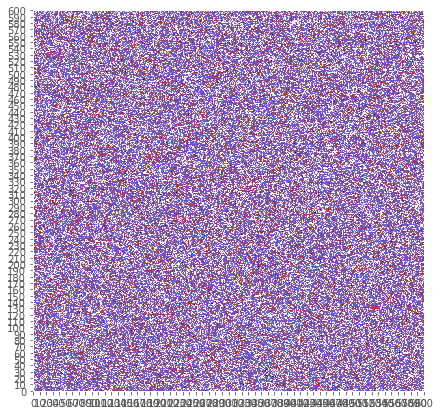

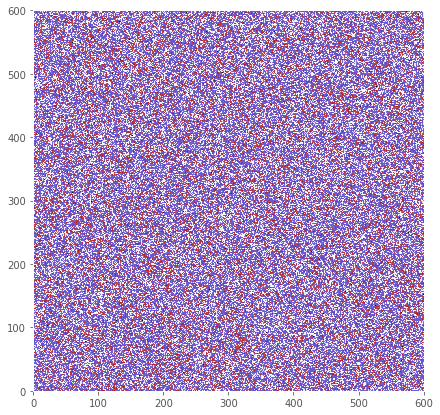

KeyboardInterrupt: ignored

In [3]:
# ================================== Set parameters here! ================================== #
citizen_density = 0.7
lattice.Ac = 9 # one “citizen agent” in our model represents `Ac` real citizens.
alwaysAcitve = 0.025 # alwaysAcitve: R
neverActive = 0.5 # neverActive: G
citizen.vision = 14 # vision(radius): V
LEO.vision = 14 
LEO_speed = 4 # LEO can take action 4 times in one time step
jailMAX = 120 
day_num = 500 # Should set to 1000 days 

np.random.seed(827)
random.seed(827)

citizen.threshold = (2 * alwaysAcitve) / (1 - neverActive) # threshold: T
citizen.legitimacy = 1 - (2 * alwaysAcitve / (neverActive * (1 - neverActive))) # legitimacy: L
# ========================================================================================== #

small_size = 100
smallCity = lattice(small_size, "Sigmoidal")
small_LEO_num = int((small_size**2) * citizen_density * 1.51 / 1000)
smallCity.place_agents(citizen_density, small_LEO_num, alwaysAcitve, neverActive)
smallCity.set_up_citizens()
smallCity.display(5)

small_record = {}
for day in range(day_num):
    smallCity.each_time_step()
    small_record[day] = ((smallCity.map == 3).sum() / smallCity.citizen_num) * 100
    if day % 100 == 0:
        print(day, end="...")
print("")    
smallCity.display()


large_size = 600
largeCity = lattice(large_size, "Sigmoidal")
large_LEO_num = int((large_size**2) * citizen_density * 2.02 / 1000)
largeCity.place_agents(citizen_density, large_LEO_num, alwaysAcitve, neverActive)
largeCity.set_up_citizens()
largeCity.display(10)

large_record = {}
for day in range(day_num):
    largeCity.each_time_step()
    large_record[day] = ((largeCity.map == 3).sum() / largeCity.citizen_num) * 100
    if day % 50 == 0:
        largeCity.display()
largeCity.display()

In [ ]:
plt.plot(list(small_record.keys()), list(small_record.values()), '-')
plt.plot(list(large_record.keys()), list(large_record.values()), '-')
plt.xlabel("Times (days)")
plt.ylabel("Acitve citizenes (%)")
plt.style.use('seaborn-white')
plt.show()

## For Demo

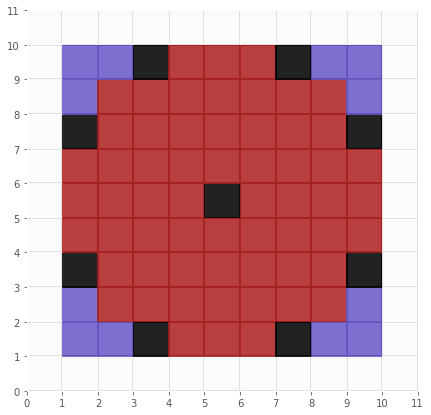

In [4]:
# size = 51
# position_x = 25
# position_y = 25
# radius = 14

size = 11
position_x = 5
position_y = 5
radius = 4

testLattice = lattice(size, "Step")
testLattice.unoccupied_position_index = list(range(size**2))

testLattice.set_status_ID(position_x, position_y, 1, 10)

for i in range(-radius, radius+1):
    for j in range(-radius, radius+1):
        testLattice.set_status_ID(position_x+i, position_y+j, 1, 10)
        if abs(i) + abs(j) > radius * 1.5 :
            testLattice.set_status_ID(position_x+i, position_y+j, 2, 10)
        d = get_distant((position_x+i, position_y+j), (position_x, position_y)) # 用圓心（但可用左下角的座標代替）來計算兩個格子的距離
        if d <= (radius + 0.25) and not (i == 0 and j == 0): # 關鍵是半徑要加 0.25, But WHY?
            testLattice.set_status_ID(position_x+i, position_y+j, 3, 10)

testLattice.display(1, 1)

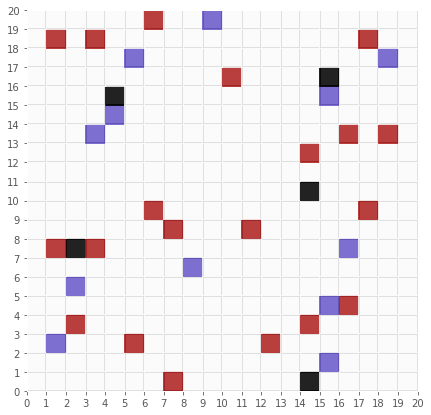

16 15


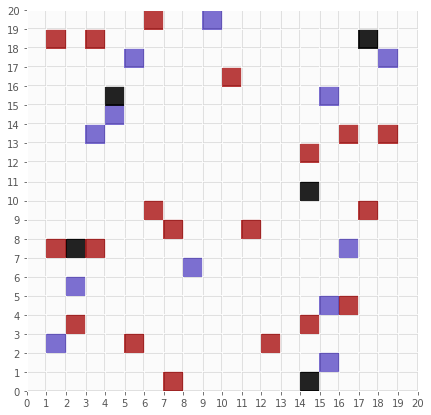

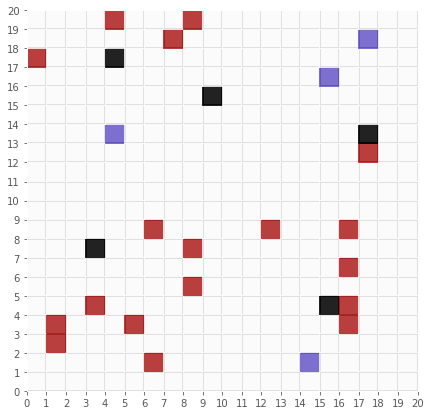

In [5]:
size = 20
citizen_density = 0.08
LEO_num = 5 # 應該要反著給！
alwaysAcitve = 0.65 # alwaysAcitve: R
neverActive = 0.1 # neverActive: G
citizen.vision = 4 # vision(radius): V
LEO.vision = 4 
LEO_speed = 1
lattice.Ac = 9
jailMAX = 120 # (days)
functionForm = "step"

np.random.seed(87)
random.seed(87)

citizen.threshold = (2 * alwaysAcitve) / (1 - neverActive) # threshold: T
citizen.legitimacy = 1 - (2 * alwaysAcitve / (neverActive * (1 - neverActive))) # legitimacy: L
# ========================================================================================== #

testlattice = lattice(size, functionForm)
testlattice.place_agents(citizen_density, LEO_num, alwaysAcitve, neverActive)
# testlattice.display(1, 1)
# testlattice.get_info()

testlattice.citizens[1].move(testlattice)
testlattice.LEOs[1].move(testlattice)
testlattice.display(1, 1)

testlattice.citizens[2].set_perceivedNetRisk(testlattice, functionForm)

print(testlattice.LEOs[1].position_x, testlattice.LEOs[1].position_y)
testlattice.LEOs[1].arrest(testlattice)
testlattice.display(1, 1)

# print(testlattice.IDMap)
# a = testlattice.get_status_in_vision(3, 2, 7)

testlattice.each_time_step()
testlattice.display(1, 1)